# QA head motion

In [4]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from scipy.stats import pearsonr

from himalaya.scoring import correlation_score

from util import plot, subject
from util.atlas import Atlas, get_brainmask

from constants import SUBS_STRANGERS, TRIAL_SLICES

import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [10]:
pipelines = ['nomot', 'runmot24', 'splitmot']
pipelines = ['phys', 'phys_head', 'phys_head_task', 'phys_head_task_split']

# correlate BOLD with FD

In [5]:
corrs = defaultdict(list)
corrsP = defaultdict(list)
corrsC = defaultdict(list)

for pipeline in pipelines:

    for subA in tqdm(SUBS_STRANGERS, desc=pipeline):

        prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)
        prodmaskA = prod_boxcar.astype(bool)
        compmaskA = ~prodmaskA

        dataA = subject.get_bold(subA, cache=pipeline)
        fwd = subject.get_confounds(subA)

        for trial_slice in TRIAL_SLICES:
            trial_fwd = fwd[trial_slice]
            trial_dataA = dataA[trial_slice]
            trial_pmask = prodmaskA[trial_slice]
            trial_cmask = compmaskA[trial_slice]

            corrs[pipeline].append(correlation_score(trial_dataA, trial_fwd))
            corrsP[pipeline].append(correlation_score(trial_dataA[trial_pmask], trial_fwd[trial_pmask]))
            corrsC[pipeline].append(correlation_score(trial_dataA[trial_cmask], trial_fwd[trial_cmask]))
        
    #         break
    #     break
    # break

phys_head: 100%|██████████| 58/58 [02:32<00:00,  2.63s/it]


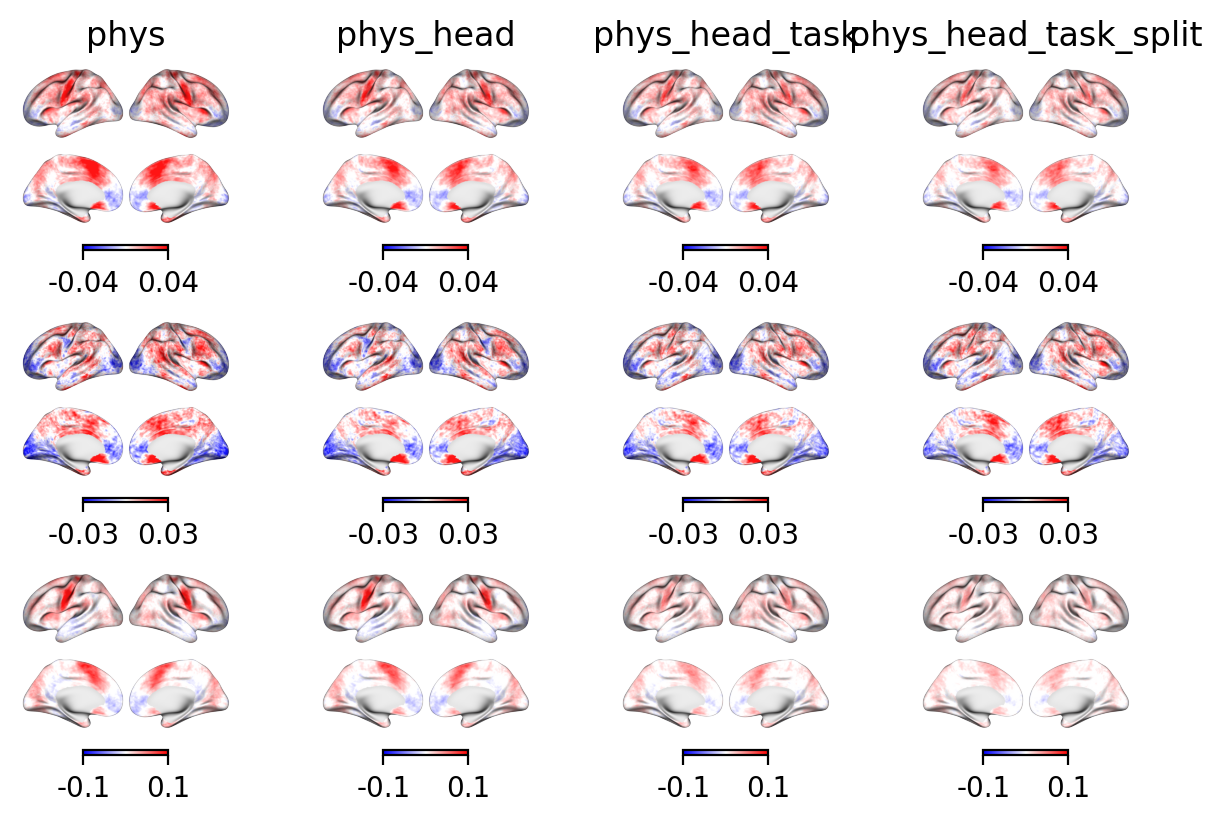

In [12]:
fig, axes = plt.subplots(3, len(pipelines), figsize=(6, 4), layout='constrained', dpi=200)

maxes = [None, None, None]
maxes = [.04, .03, .1]

for i, (result, vmax) in enumerate(zip([corrs, corrsP, corrsC], maxes)):
    for j, pipeline in enumerate(pipelines):
        ax = axes[i, j]

        values = np.nanmean(np.stack(result[pipeline]), axis=0)
        plot.surface_plot(values, fig=fig, ax=ax, cmap='bwr', vmax=vmax)

for j, pipeline in enumerate(pipelines):
    axes[0, j].set_title(pipeline)

fig.show()

In [15]:
margin = 3
margin = 0
print(margin)

corrsP = defaultdict(list)
corrsC = defaultdict(list)

for pipeline in pipelines:

    for subA in tqdm(SUBS_STRANGERS, desc=pipeline):

        dataA = subject.get_bold(subA, cache=pipeline)
        fwd = subject.get_confounds(subA)
        prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)
        prod_mask = prod_boxcar.astype(bool)
        comp_mask = ~ prod_mask

        for mask, dictionary in zip((prod_mask, comp_mask), (corrsP, corrsC)):
            chunk_bounds = np.diff(mask, prepend=0).nonzero()[0]
            for i in range(0, len(chunk_bounds), 2):
                from_idx = chunk_bounds[i] + 1
                to_idx = chunk_bounds[i+1] if i+1 < len(chunk_bounds) else len(mask)

                chunk_size = to_idx - from_idx
                if chunk_size < 16:  # NOTE arbitrary threshold
                    continue
                
                chunk_slice = slice(from_idx + margin, to_idx - margin)

                dataA_chunk = dataA[chunk_slice]
                fwd_chunk = fwd[chunk_slice]

                dictionary[pipeline].append(correlation_score(dataA_chunk, fwd_chunk))

        # break

0


phys_head_task_split: 100%|██████████| 58/58 [00:53<00:00,  1.08it/s]


In [ ]:
fig, axes = plt.subplots(2, len(pipelines), figsize=(6, 4), layout='constrained', dpi=200)

maxes = [None] * len(pipelines)

for i, (result, vmax) in enumerate(zip([corrsP, corrsC], maxes)):
    for j, pipeline in enumerate(pipelines):
        ax = axes[i, j]

        values = np.nanmean(np.stack(result[pipeline]), axis=0)
        plot.surface_plot(values, fig=fig, ax=ax, cmap='bwr', vmax=vmax)

for j, pipeline in enumerate(pipelines):
    axes[0, j].set_title(pipeline)

fig.show()

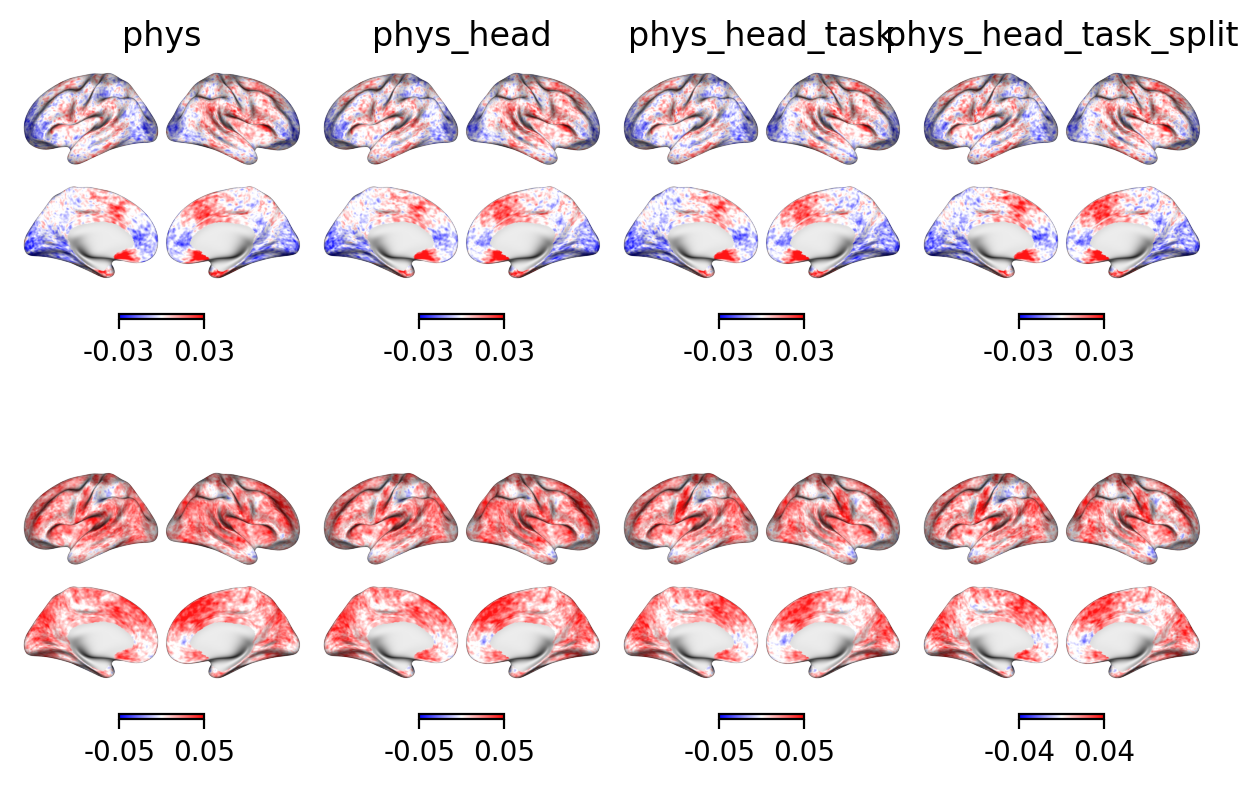

In [14]:
fig, axes = plt.subplots(2, len(pipelines), figsize=(6, 4), layout='constrained', dpi=200)

maxes = [None] * len(pipelines)

for i, (result, vmax) in enumerate(zip([corrsP, corrsC], maxes)):
    for j, pipeline in enumerate(pipelines):
        ax = axes[i, j]

        values = np.nanmean(np.stack(result[pipeline]), axis=0)
        plot.surface_plot(values, fig=fig, ax=ax, cmap='bwr', vmax=vmax)

for j, pipeline in enumerate(pipelines):
    axes[0, j].set_title(pipeline)

fig.show()

In [5]:
# a few nan's when only one person spoke the entire trial
# np.nonzero(np.isnan(values.reshape((58, 10, -1)).sum(-1)))

## just testing

In [48]:
corrs = correlation_score(trial_dataA, trial_fwd)
corrsP = correlation_score(trial_dataA[trial_pmask], trial_fwd[trial_pmask])
corrsC = correlation_score(trial_dataA[trial_cmask], trial_fwd[trial_cmask])

In [16]:
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

In [50]:
X = trial_fwd
Y = trial_dataA

X = zscore(X)
Y = np.nan_to_num(zscore(Y))

model = LinearRegression(fit_intercept=False).fit(X, Y)
model.coef_.shape, pearsonr(model.coef_.ravel(), corrs)

((81924, 1), PearsonRResult(statistic=0.999999999999979, pvalue=0.0))

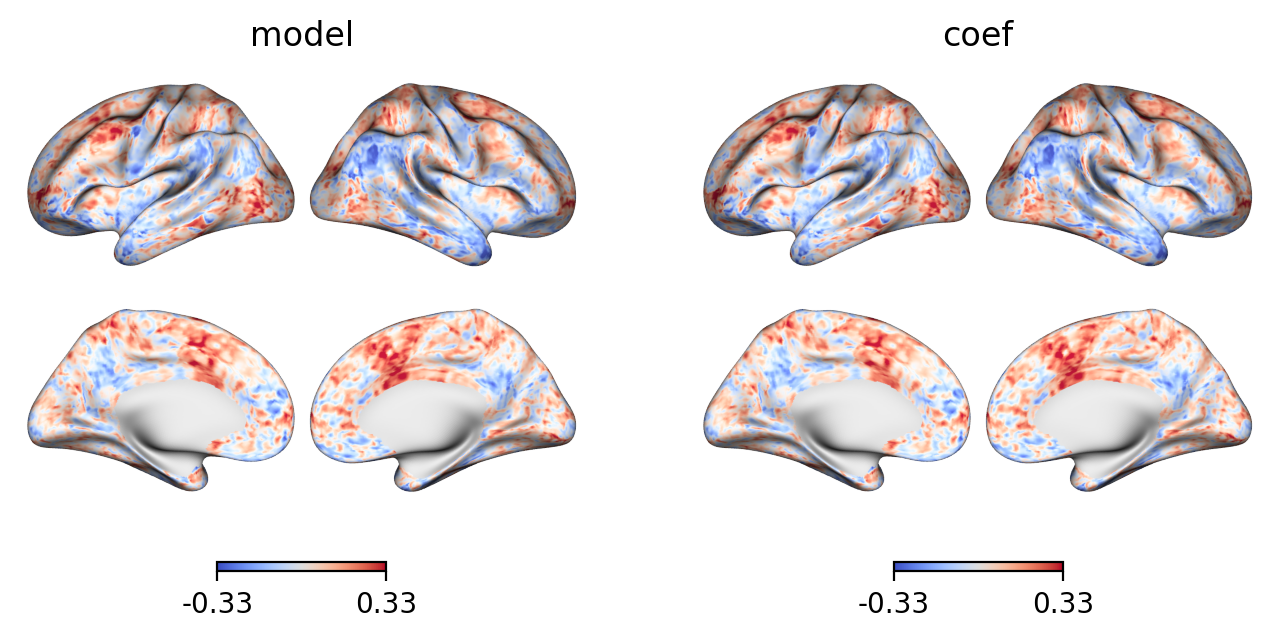

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200)
plot.surface_plot(model.coef_, fig=fig, ax=axes[0], title='model')
plot.surface_plot(corrs, fig=fig, ax=axes[1], title='coef')
fig.show()

In [42]:
X = np.stack((trial_pmask, zscore(trial_fwd.ravel()))).T

Y = trial_dataA
Y = np.nan_to_num(zscore(Y))

model = LinearRegression(fit_intercept=False).fit(X, Y)
print(model.coef_.shape)

prod_coef = model.coef_.sum(-1)
comp_coef = model.coef_[:, 1]

(81924, 2)


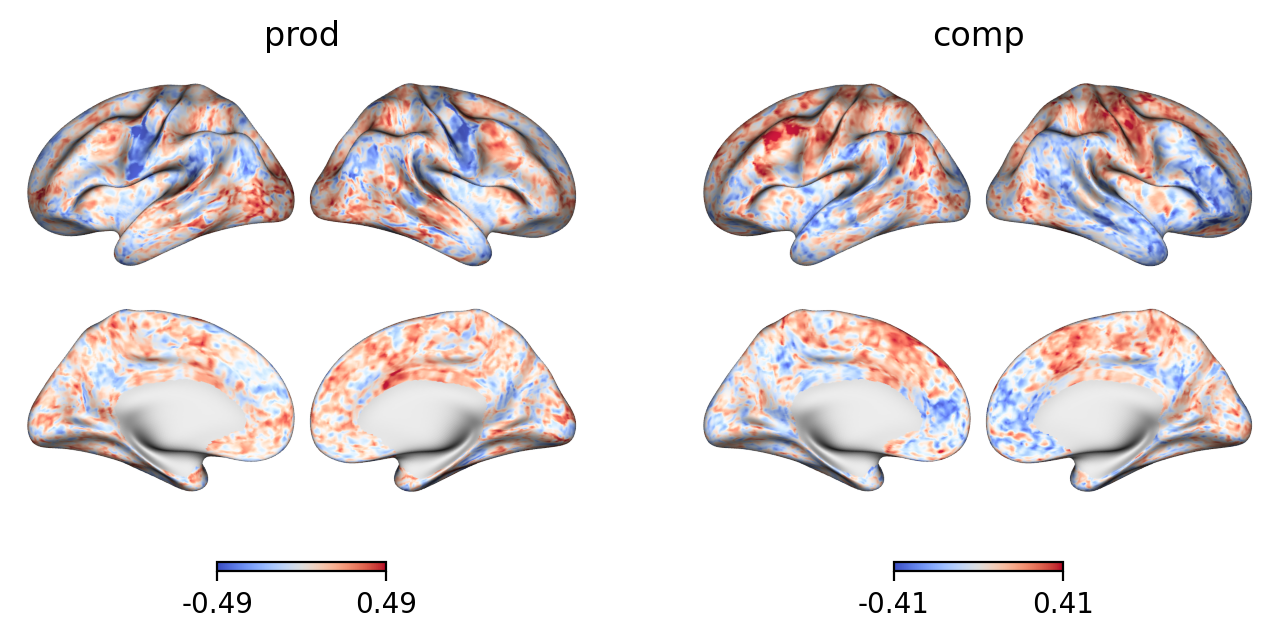

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200)
plot.surface_plot(corrsP, fig=fig, ax=axes[0], title='prod')
plot.surface_plot(corrsC, fig=fig, ax=axes[1], title='comp')
fig.show()

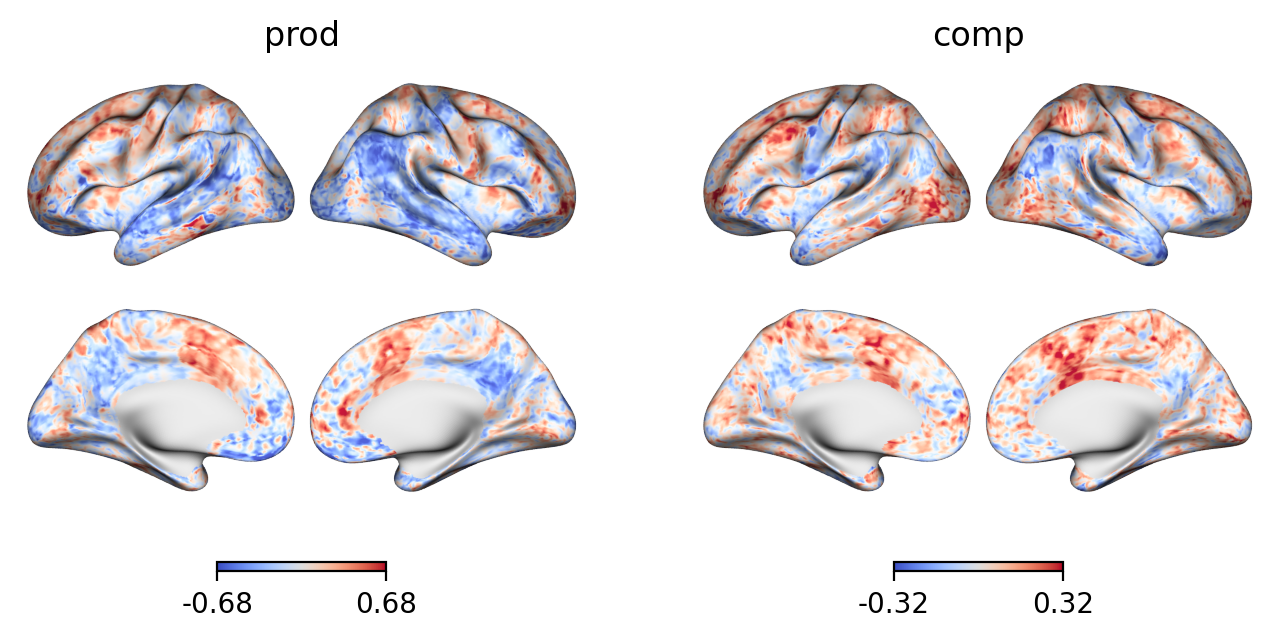

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200)
plot.surface_plot(prod_coef, fig=fig, ax=axes[0], title='prod')
plot.surface_plot(comp_coef, fig=fig, ax=axes[1], title='comp')
fig.show()

## violin plots

In [34]:
schaefer = Atlas.schaefer(100)
eac_mask = schaefer.roimask(['17Networks_LH_SomMotB_Aud_1'])
mot_mask = schaefer.roimask(['17Networks_LH_SomMotB_Cent_1'])

FG_MASK = get_brainmask()

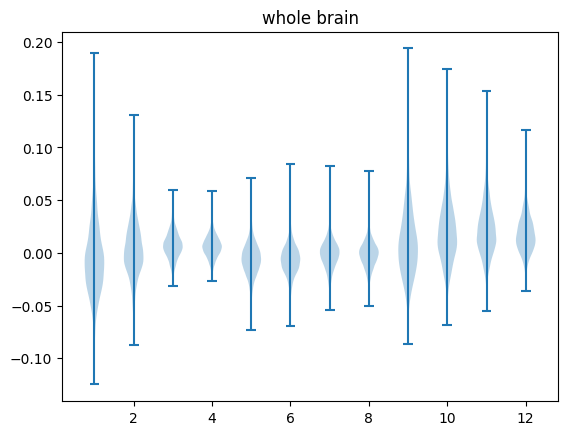

In [39]:
plt.violinplot([np.nanmean(np.stack(result[pipeline])[..., FG_MASK], axis=0) for result in (corrs, corrsP, corrsC) for pipeline in pipelines])
plt.title("whole brain")
plt.show()

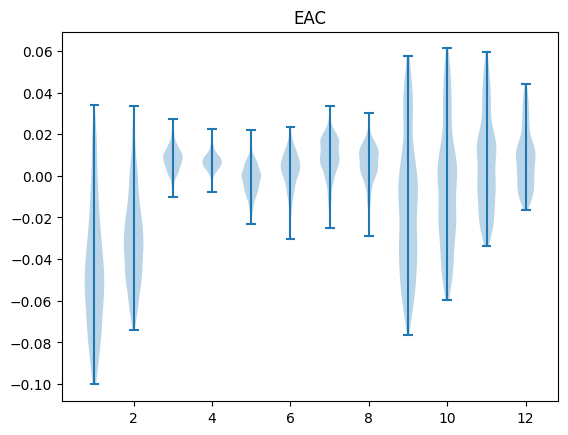

In [37]:
plt.violinplot([np.nanmean(np.stack(result[pipeline])[..., eac_mask], axis=0) for result in (corrs, corrsP, corrsC) for pipeline in pipelines])
plt.title("EAC")
plt.show()

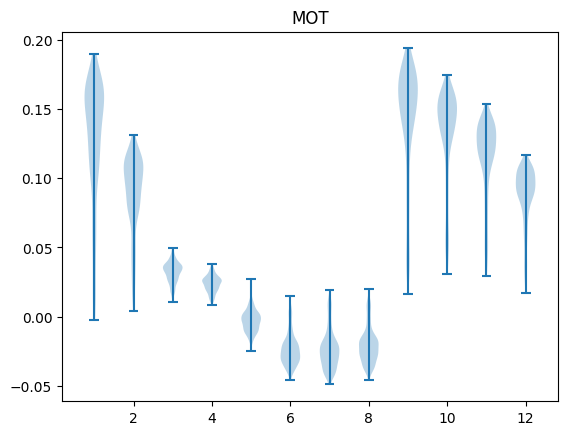

In [38]:
plt.violinplot([np.nanmean(np.stack(result[pipeline])[..., mot_mask], axis=0) for result in (corrs, corrsP, corrsC) for pipeline in pipelines])
plt.title("MOT")
plt.show()

## plot single trial

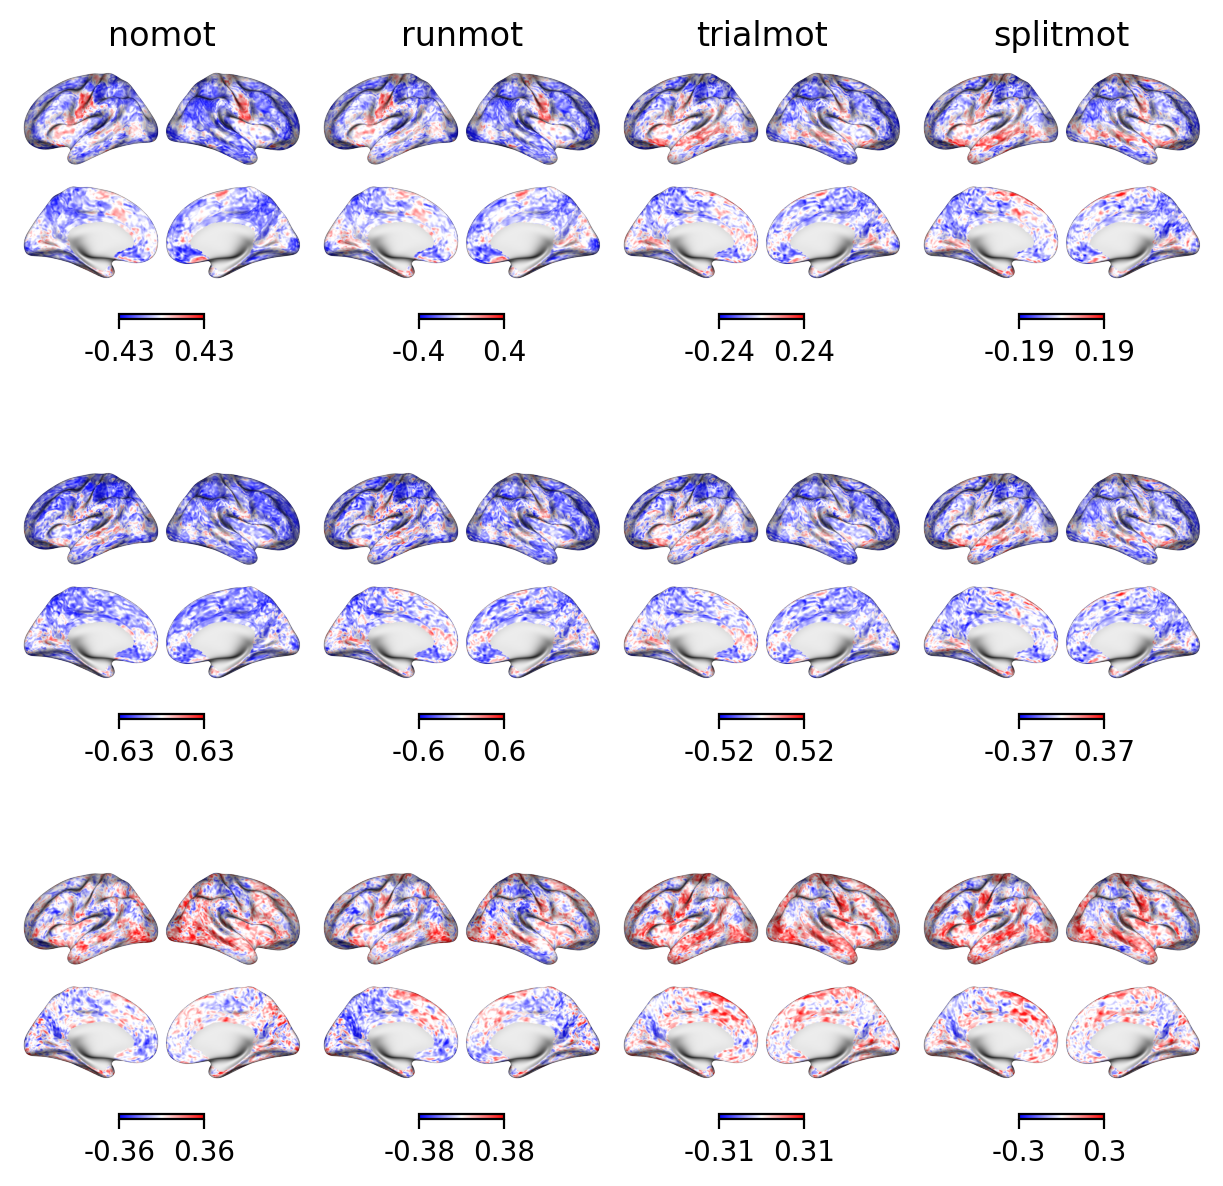

In [11]:
fig, axes = plt.subplots(3, len(pipelines), figsize=(6, 6), layout='constrained', dpi=200)

for i, result in enumerate([corrs, corrsP, corrsC]):
    for j, pipeline in enumerate(pipelines):
        ax = axes[i, j]

        values = result[pipeline][100]
        plot.surface_plot(values, fig=fig, ax=ax, cmap='bwr')#, vmax=0.5)

for j, pipeline in enumerate(pipelines):
    axes[0, j].set_title(pipeline)

fig.show()

## plot group average

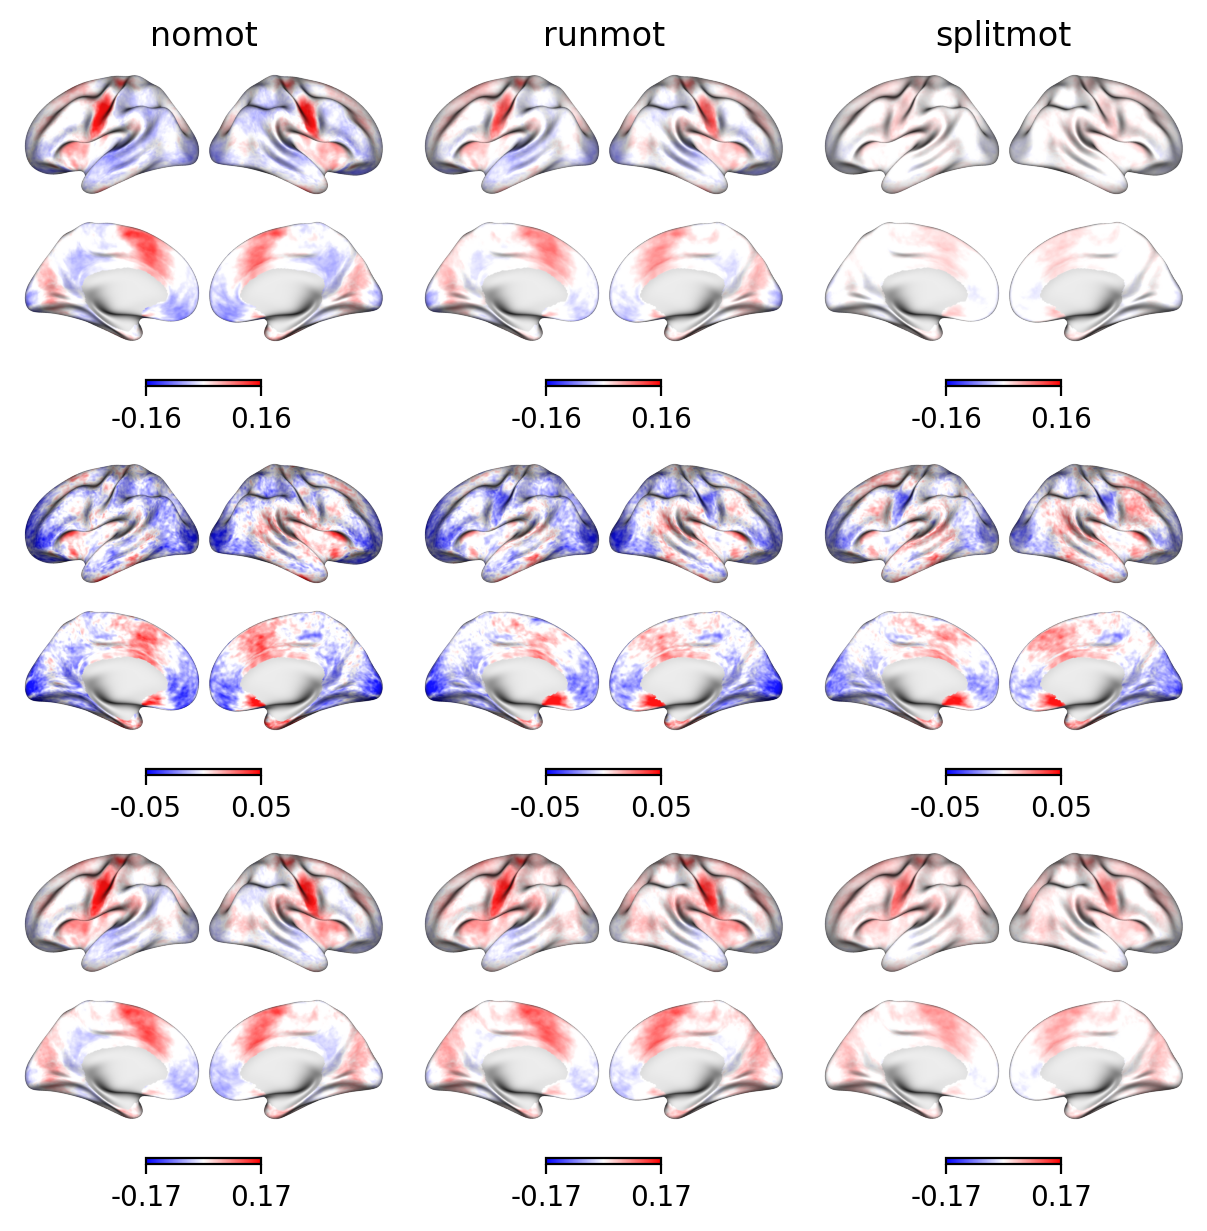

In [9]:
fig, axes = plt.subplots(3, len(pipelines), figsize=(6, 6), layout='constrained', dpi=200)

maxes = [0.16, 0.05, 0.17]

for i, (result, vmax) in enumerate(zip([corrs, corrsP, corrsC], maxes)):
    for j, pipeline in enumerate(pipelines):
        ax = axes[i, j]

        values = np.nanmean(np.stack(result[pipeline]), axis=0)
        plot.surface_plot(values, fig=fig, ax=ax, cmap='bwr', vmax=vmax)

for j, pipeline in enumerate(pipelines):
    axes[0, j].set_title(pipeline)

fig.show()

# confirm FD

In [4]:
def build_epochs(
    values: np.ndarray, onsets: np.ndarray, tmin: int = 5, tmax: int = 5
) -> np.ndarray:
    epochs = []
    for onset in onsets:
        start, end = onset - tmin, onset + tmax
        if start > 0 and end < values.size:
            epochs.append(values[start : end + 1])
    return np.stack(epochs).squeeze()

In [5]:
sub_fd = []
sub_boxcars = []
sub_button_idsP = []
sub_button_idsC = []

for sub_id in tqdm(SUBS_STRANGERS):
    fd = subject.get_confounds(sub_id)
    prod_boxcar, button_idsA, button_idsB = subject.get_timinglog_boxcars(sub_id)

    sub_fd.append(fd)
    sub_boxcars.append(prod_boxcar)
    sub_button_idsP.append(button_idsA)
    sub_button_idsC.append(button_idsB)

sub_fd = np.stack(sub_fd).squeeze()
sub_boxcars = np.stack(sub_boxcars)

100%|██████████| 58/58 [00:13<00:00,  4.46it/s]


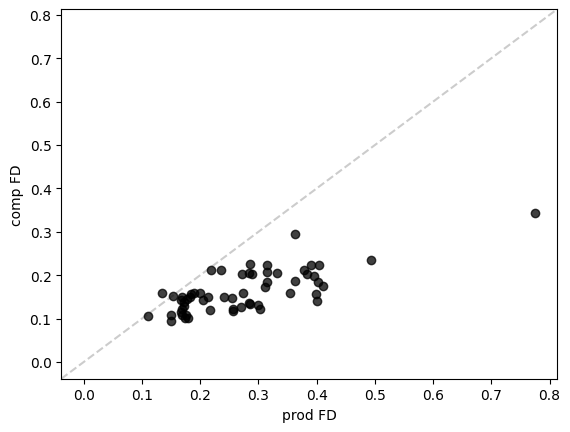

In [6]:
avg_prod_fd = [fd[bc.astype(bool)].mean() for fd, bc in zip(sub_fd, sub_boxcars)]
avg_comp_fd = [fd[~(bc.astype(bool))].mean() for fd, bc in zip(sub_fd, sub_boxcars)]

fig, ax = plt.subplots()
ax.scatter(avg_prod_fd, avg_comp_fd, c='k', marker='o', alpha=0.75)
ax.axline((0,0), slope=1, c='k', alpha=0.2, ls='dashed')
ax.set(xlabel='prod FD', ylabel='comp FD')
ax.set_ylim(ax.get_xlim())
fig.show()

In [46]:
sub_corrs = [pearsonr(fd.squeeze(), bc)[0] for fd, bc in zip(sub_fd, sub_boxcars)]
sub_diffs = np.array(avg_prod_fd) - np.array(avg_comp_fd)

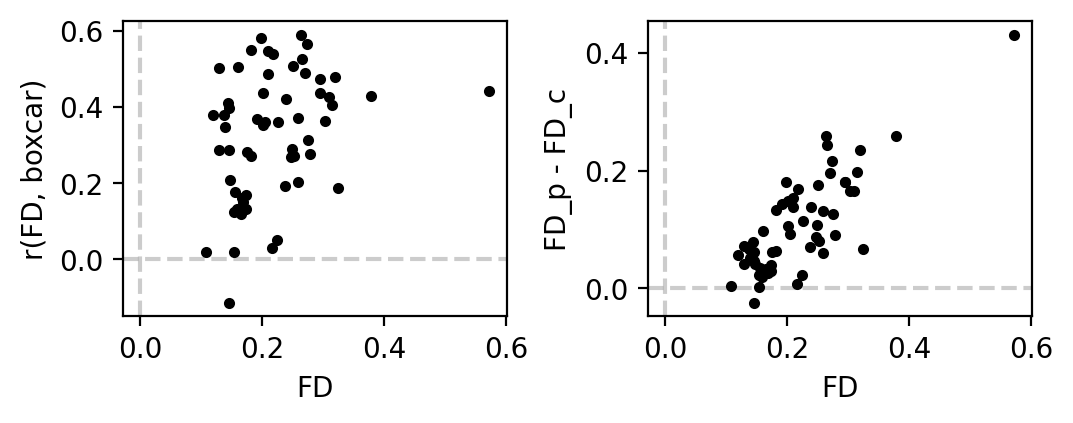

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(5.25, 2), dpi=200, layout='constrained')

ax = axes[0]
ax.scatter(sub_fd.mean(-1), sub_corrs, c='k', marker='.')
ax.set(xlabel='FD', ylabel='r(FD, boxcar)')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')
ax.axvline(0, c='k', alpha=0.2, ls='dashed')

ax = axes[1]
ax.scatter(sub_fd.mean(-1), sub_diffs, c='k', marker='.')
ax.set(xlabel='FD', ylabel='FD_p - FD_c')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')
ax.axvline(0, c='k', alpha=0.2, ls='dashed')


fig.show()

In [52]:
sub_id = 105
fd = subject.get_confounds(sub_id)
prod_boxcar, button_idsA, button_idsB = subject.get_timinglog_boxcars(sub_id)

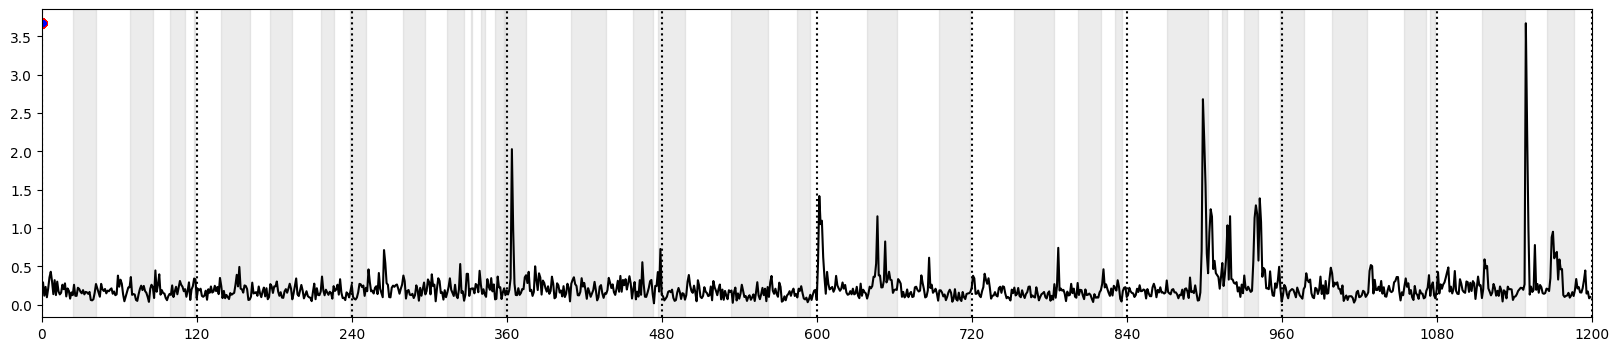

In [53]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(fd, c='k')
# ax.plot(prod_boxcar * fd.max(), c='k', zorder=1, alpha=0.5)

ax.scatter(button_idsA, np.ones_like(button_idsA) * fd.max(), marker='o', c='r')
ax.scatter(button_idsB, np.ones_like(button_idsB) * fd.max(), marker='.', c='b')

# something wrong with this logic? for some subs
switches = [0] + np.nonzero(np.diff(prod_boxcar))[0].tolist()
for i in range(1, len(switches)):
    if i % 2 == 0:
        ax.axvspan(switches[i - 1], switches[i], color="gray", alpha=0.15, zorder=1)

ax.set_xticks(range(0, 1201, 120))
for i in ax.get_xticks():
    ax.axvline(i, c='k', ls='dotted', zorder=1)

# r = 2
# ax.set_xlim(240*r, 240*(r+1))

ax.set_xlim(0, 1200)
fig.show()